In [111]:
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [112]:
gpus = tf.config.list_physical_devices('GPU')
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [113]:
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [114]:
df = pd.read_csv('./data/merged.csv')
# df = pd.read_csv('../data/merged_labeled_daily.csv')

In [115]:
df = df.drop(columns=df.columns[:2])
df['measure_date'] = pd.to_datetime(df['measure_date'])
df['year'] = df['measure_date'].dt.year
df['month'] = df['measure_date'].dt.month
df['day'] = df['measure_date'].dt.day
df['weekday'] = df['measure_date'].dt.weekday
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)
df['day_cos'] = np.cos(2 * np.pi * df['day'] / 31)

In [116]:
df.head()

,station_code,measure_date,HS,no_snow,anomaly,year,month,day,weekday,month_sin,month_cos,day_sin,day_cos
0,AMD2,1997-10-14,12.0,False,False,1997,10,14,1,-0.866025,0.5,0.299363,-0.954139
1,AMD2,1997-10-15,31.0,False,False,1997,10,15,2,-0.866025,0.5,0.101168,-0.994869
2,AMD2,1997-10-16,9.0,False,False,1997,10,16,3,-0.866025,0.5,-0.101168,-0.994869
3,AMD2,1997-10-17,16.0,False,False,1997,10,17,4,-0.866025,0.5,-0.299363,-0.954139
4,AMD2,1997-10-18,-4.0,True,False,1997,10,18,5,-0.866025,0.5,-0.485302,-0.874347


In [117]:
num_train_stations = 15
stations = df['station_code'].unique()

train_val_end_index = df[df['station_code'] == stations[num_train_stations - 1]].index[-1] + 1

num_train_samples = int(0.7 * train_val_end_index)
num_val_samples = train_val_end_index - num_train_samples
num_test_samples = len(df) - train_val_end_index

print("Train length: %s" % num_train_samples)
print("Validation length: %s" % num_val_samples)
print("Test length: %s" % num_test_samples)

total = num_train_samples + num_val_samples + num_test_samples
print(total, len(df), total == len(df))

Train length: 88601
Validation length: 37972
Test length: 42749
169322 169322 True


In [118]:
features = df[['HS', 'day_sin', 'day_cos', 'month_sin', 'month_cos']].values
target = df[['no_snow']].values

In [119]:
mean = features[:num_train_samples].mean(axis=0)
features -= mean
std = features[:num_train_samples].std(axis=0)
features /= std
features

array([[-0.65719526,  0.41694945, -1.33643084, -1.22485271,  0.69111721],
       [-0.46035473,  0.13911521, -1.39456923, -1.22485271,  0.69111721],
       [-0.68827535, -0.14452516, -1.39456923, -1.22485271,  0.69111721],
       ...,
       [ 0.2783153 ,  1.10582347, -0.84821005,  1.23528619,  0.69111721],
       [ 0.23791118,  0.91040464, -1.05754238,  1.23528619,  0.69111721],
       [ 0.26277525,  0.67760299, -1.22253424,  1.23528619,  0.69111721]])

In [120]:
print(target[:3])
print(features[:3])

[[False]
 [False]
 [False]]
[[-0.65719526  0.41694945 -1.33643084 -1.22485271  0.69111721]
 [-0.46035473  0.13911521 -1.39456923 -1.22485271  0.69111721]
 [-0.68827535 -0.14452516 -1.39456923 -1.22485271  0.69111721]]


In [121]:
def sequence_debugging():
    int_sequence = np.arange(30)

    train_end_index = int(0.5 * len(int_sequence))
    val_end_index = int(0.75 * len(int_sequence))

    sequence_length = 3
    target_start_idx = sequence_length - 1

    train_dataset = keras.utils.timeseries_dataset_from_array(
        data=int_sequence,
        targets=int_sequence[target_start_idx:],
        sequence_length=sequence_length,
        start_index=0,
        end_index=train_end_index
    )

    val_dataset = keras.utils.timeseries_dataset_from_array(
        data=int_sequence,
        targets=int_sequence[target_start_idx:],
        sequence_length=sequence_length,
        start_index=train_end_index,
        end_index=val_end_index
    )

    test_dataset = keras.utils.timeseries_dataset_from_array(
        data=int_sequence,
        targets=int_sequence[target_start_idx:],
        sequence_length=sequence_length,
        start_index=val_end_index
    )

    print("Train:")
    for inputs, targets in train_dataset:
        for i in range(inputs.shape[0]):
            print([int(x) for x in inputs[i]], int(targets[i]))

            
    print("\nVal:")
    for inputs, targets in val_dataset:
        for i in range(inputs.shape[0]):
            print([int(x) for x in inputs[i]], int(targets[i]))

    print("\nTest:")
    for inputs, targets in test_dataset:
        for i in range(inputs.shape[0]):
            print([int(x) for x in inputs[i]], int(targets[i]))

In [122]:
import numpy as np
from tensorflow import keras

sequence_length = 30
sequence_stride = 1
sampling_rate = 1
sequence_batch_size = 128
# batch_size = None
shuffle_train_val = True
shuffle_test = False
start_index = 0

def create_dataset(start_index, end_index, shuffle=False):
    return keras.utils.timeseries_dataset_from_array(
        data=features,
        targets=target[target_start_idx:],
        sequence_length=sequence_length,
        sequence_stride=sequence_stride,
        sampling_rate=1,
        batch_size=sequence_batch_size,
        shuffle=shuffle,
        start_index=start_index,
        end_index=end_index
    )

target_start_idx = sequence_length - 1

train_dataset = create_dataset(start_index=0, end_index=num_train_samples, shuffle=shuffle_train_val)
val_dataset = create_dataset(start_index=num_train_samples, end_index=num_train_samples + num_val_samples, shuffle=shuffle_train_val)
test_dataset = create_dataset(start_index=num_train_samples + num_val_samples, end_index=(len(df) - 1), shuffle=shuffle_test)

In [ ]:
model = keras.Sequential([
    keras.layers.LSTM(
        256,
        input_shape=(sequence_length, features.shape[-1]),
        return_sequences=True,
        dropout=0.6,
        recurrent_dropout=0.3
    ),
    keras.layers.LSTM(
        128,
        input_shape=(sequence_length, features.shape[-1]),
        return_sequences=True,
        dropout=0.6,
        recurrent_dropout=0.3
    ),
    keras.layers.Dropout(0.6),
    keras.layers.LSTM(
        64,
        dropout=0.6,
        recurrent_dropout=0.3
    ),
    keras.layers.Dropout(0.6),
    keras.layers.Dense(8, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid"),
])

model.compile(
    optimizer='adam',
    metrics='accuracy',
    loss='binary_crossentropy'
)

arch = "256-128-64-8(d)-1"
epochs = 50
model_batch_size = 64

current_time = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
model_name = f"{current_time}_arch-{arch}_epochs-{epochs}_batch-{model_batch_size}_seq-{sequence_length}_num-train-stations-{num_train_stations}"
log_dir = f"./logs/{model_name}"

history = model.fit(
    train_dataset,
    epochs=5,
    batch_size=model_batch_size,
    validation_data=val_dataset,
    callbacks=[
        keras.callbacks.ModelCheckpoint('snow_height_anomaly_multi_vars.keras', save_best_only=True),
        keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1) 
    ]
)

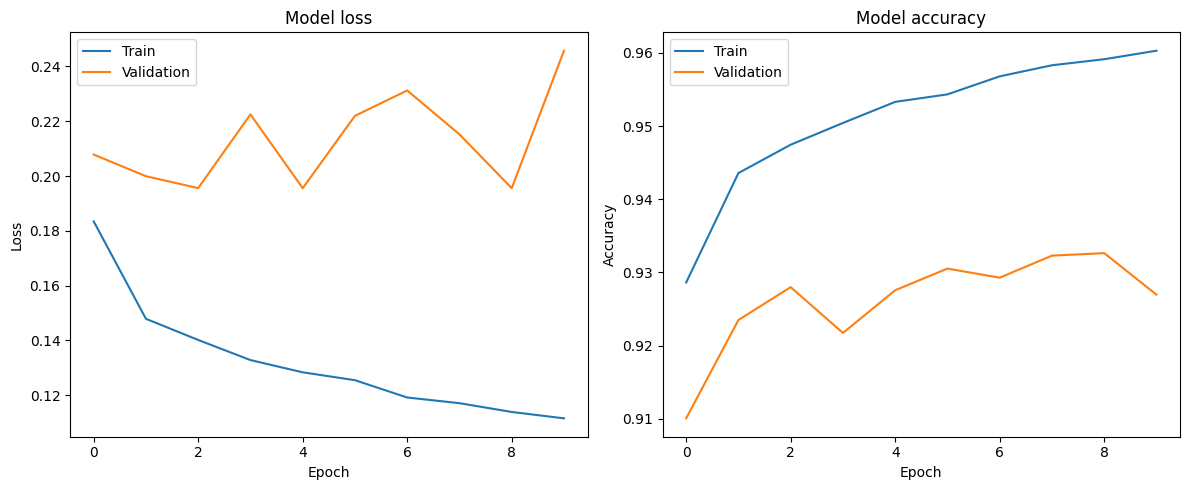

In [100]:
def plot_keras_history(history):
    # Plot training & validation loss values
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

plot_keras_history(history)

In [99]:
model.evaluate(test_dataset)

334/334 [==============================] - 6s 19ms/step - loss: 0.2098 - accuracy: 0.9302


[0.20979706943035126, 0.9302118420600891]

In [102]:
def plot_data(dfs, y='HS', target='no_snow', predictions=None):
    if not isinstance(dfs, list):
        dfs = [dfs]

    if not isinstance(predictions, list):
        predictions = [predictions] if predictions else []

    if not isinstance(y, list):
        y = [y] * len(dfs)

    if not isinstance(target, list):
        target = [target] * len(dfs)

    if len(predictions):
        rows = len(dfs) * 2
    else:
        rows = len(dfs)

    fig, axes = plt.subplots(rows, 1, figsize=(20, 5 * rows))

    if not isinstance(axes, np.ndarray):
        axes = [axes]

    for i, df in enumerate(dfs):
        plot_df = df.copy()
        plot_df.index = pd.to_datetime(plot_df['measure_date'])
        station_code = plot_df['station_code'].iloc[0]

        # Plot original data
        ax = axes[2 * i] if len(predictions) else axes[i]
        ax.set_xlabel('Date')
        ax.set_ylabel(y[i])
        ax.set_title(f'Station: {station_code} | Original Data with Anomalies Highlighted')
        ax.plot(plot_df.index, plot_df[y[i]], label='Data', marker='o', linestyle='-', ms=4)
        ax.scatter(plot_df[plot_df[target[i]]].index, plot_df[plot_df[target[i]]][y[i]], color='red', label='Anomalies', zorder=5, s=20)
        ax.legend()

        # Plot predictions
        if len(predictions):
            ax = axes[2 * i + 1]
            ax.set_xlabel('Date')
            ax.set_ylabel(y[i])
            ax.set_title(f'Station: {station_code} | Predicted Data with Anomalies Highlighted')
            ax.plot(plot_df.index, plot_df[y[i]], label='Data', marker='o', linestyle='-', ms=4)
            ax.scatter(plot_df[predictions[i]].index, plot_df[predictions[i]][y[i]], color='green', label='Predicted Anomalies', zorder=5, s=20)
            ax.legend()

    plt.tight_layout()
    plt.show()
model.evaluate(train_dataset)

692/692 [==============================] - 11s 16ms/step - loss: 0.1137 - accuracy: 0.9580


[0.11371319741010666, 0.9580479860305786]

86/86 [==============================] - 2s 17ms/step


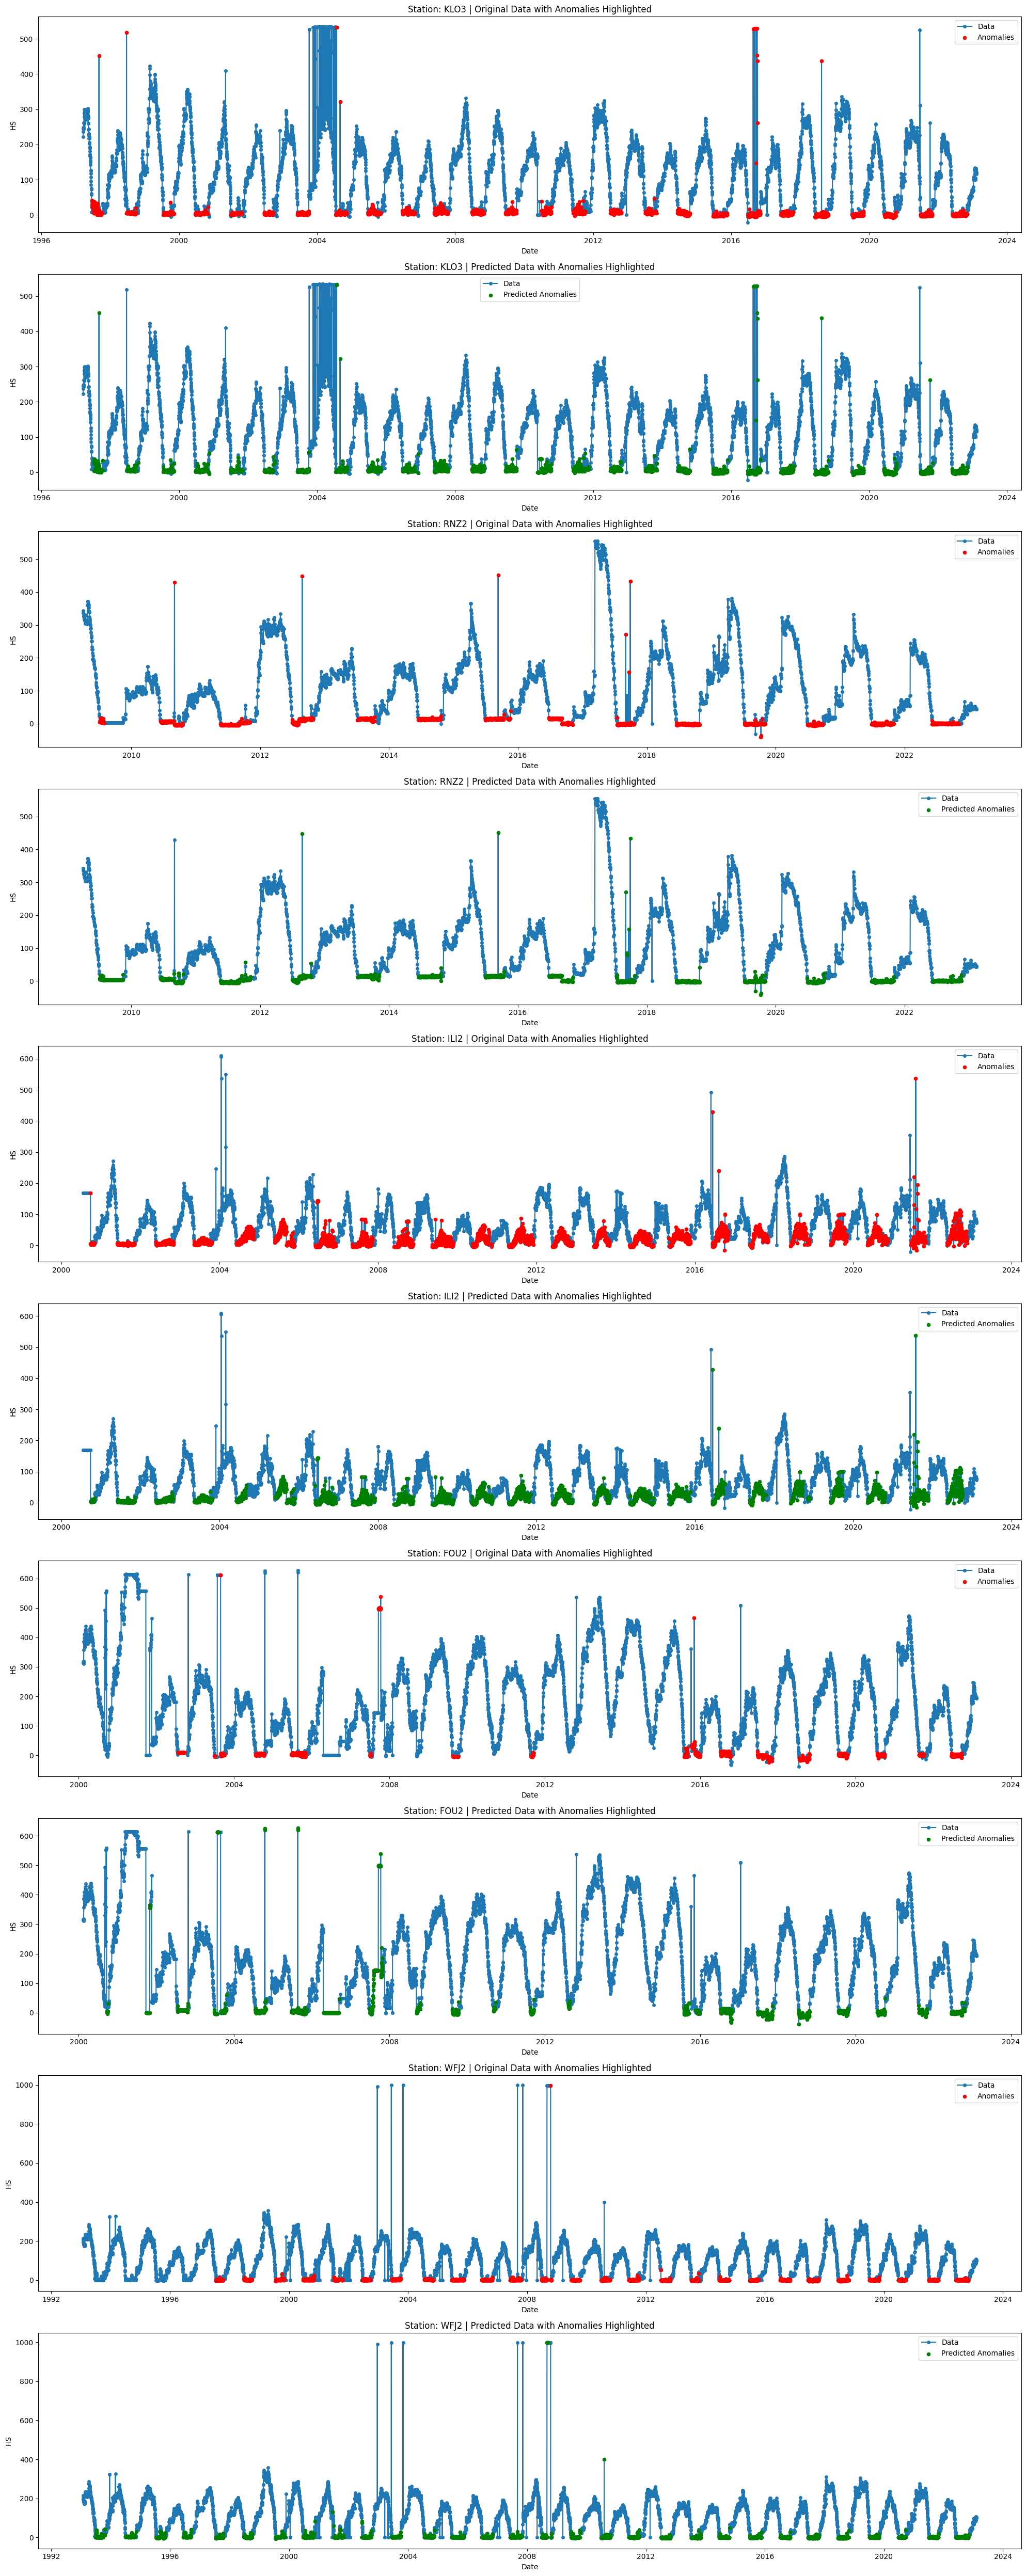

In [103]:
test_stations = df[train_val_end_index:]['station_code'].unique()
test_stations = [(df[df['station_code'] == station].index.values[[0, -1]], df[df['station_code'] == station][sequence_length:]) for station in test_stations]
predictions = [model.predict(create_dataset(station[0][0], station[0][1])).reshape((-1,)) > 0.5 for station in test_stations]

plot_data(
    [station[1] for station in test_stations],
    predictions=predictions
)